<a href="https://colab.research.google.com/github/LukszaLab/CFITworkshop/blob/main/Immunoediting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/LukszaLab/CFITworkshop.git
%cd CFITworkshop

Cloning into 'CFITworkshop'...
remote: Enumerating objects: 1140, done.
remote: Total 1140 (delta 0), reused 0 (delta 0), pack-reused 1140 (from 1)
Receiving objects: 100% (1140/1140), 66.24 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Updating files: 100% (1698/1698), done.
/content/CFITworkshop


In [ ]:
import json
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cfit.fitness.HLAweights import HLAweights
from cfit.fitness.ImmuneCloneFitness import ImmuneCloneFitness
from cfit.fitness.VariableImmuneCloneFitness import VariableImmuneCloneFitness
from cfit.fitness.DGCloneFitness import DGCloneFitness
from cfit.fitness.neo_quality.ARNeoantigenQuality import ARNeoantigenQuality
from cfit.plot.PlotTreeAll import PlotTreeAll
from cfit.tree.mutation.Neoantigen import Neoantigen
from cfit.util.Analysis import Analysis
from cfit.util.Analysis import AnalysisArgs
from cfit.util.Log import Log
from cfit.util.Utils import Utils
from scipy.stats import pearsonr, linregress

import scipy
import seaborn as sns


**Data**

In [ ]:
hdir='test/Data_orig'

In [ ]:
args = AnalysisArgs()
args.netMHC = "3.4"
args.kd_thr = 500 # threshold on neoantigen Kd
args.dir = hdir
odir = os.path.join(args.dir, "ntau_AR_"+args.netMHC)
if not os.path.exists(odir):
    os.mkdir(odir)

In [ ]:
a = 26.
k = 1.
Neoantigen.WEPS = 0.0
tau = 0.04
npos = "1-9"

modelParamValues = [a, k, tau]
modelParamNames = ["a", "k", "tau"]

,a,k,tau
0,26.0,1.0,0.04


In [ ]:
anl = Analysis()
anl.set_MHC_version(args.netMHC)
mappingfile = os.path.join(args.dir, "mapping.json")
with open(mappingfile) as f:
    mappingjs = json.load(f)
configfile = os.path.join(args.dir, "config.json")
with open(configfile) as f:
    configjs = json.load(f)
vcfdir = os.path.join(args.dir, configjs["vcf_dir"])
alndir = os.path.join(args.dir, configjs["aln_dir"])
iedbfasta = os.path.join(alndir, "enemy.fasta")

anl.clonal = 1  # whether to take the trees into account in the analysis, 1 - yes
anl.ntrees = args.ntrees  # number of top scoring trees
anl.initialize_config(configjs, mappingjs, args=args)

In [ ]:
HLAW = HLAweights('1-9')
Qmodel = ARNeoantigenQuality(alndir=alndir, iedbfasta=iedbfasta)
anl.set_neantigen_quality_model(Qmodel)
anl.compute_neoantigen_sample_qualities(a=a, k=k, HLAW=HLAweights('1-9'), include_A=True, include_R=True,kdthr=args.kd_thr, KDnormalize=1.)


In [ ]:
# set fitness components

#anl.set_fitness_model_component(quantityFitnessModelComp, "immune", 1.)

#fitnessModelComp2 = DGCloneFitness(genes=["TP53","KRAS","CDKN2A", "SMAD4"])

#anl.set_fitness_model_component(fitnessModelComp2, "dg", 0.0)

# perform evolutionary predictions:

# 1. compute neoantigen qualities
qualityFitnessModelComp = ImmuneCloneFitness(aggrfun=max)
anl.set_fitness_model_component(qualityFitnessModelComp, "immune", 1.)

#quantityFitnessModelComp = VariableImmuneCloneFitness(quality_function=lambda neo, sampleTree, sample: 1, aggrfun=sum)
#anl.set_fitness_model_component(quantityFitnessModelComp, "immune", 1.)


# 2. compute fitness of all clones
anl.compute_node_fitness(recompute_components=True)

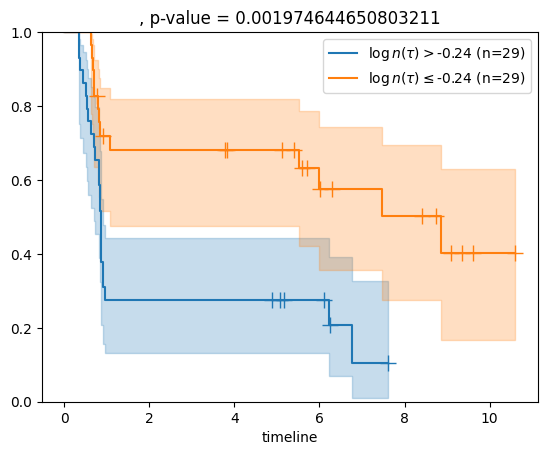

In [ ]:
# Survival analysis
pof_surv = open(os.path.join(odir, "pvalues_survival.txt"), 'w')
Utils.writelineHeader(pof_surv, modelParamNames=modelParamNames)

quantile = 0.5
res_surv = anl.classify_survival(beta=1., tau=tau, outdir=None, OS=True, PFS=True, quantile=quantile)
modelParamValues = [a, k, tau, quantile]
Utils.writeline(anl, "AR", res_surv, modelParamValues, Neoantigen.WEPS,
                        "AR", pof=pof_surv)
pof_surv.close()
anl.plot_survival(os.path.join(odir, "survival_plot_OS_q_"+str(quantile)+".pdf"),
                  OS=True, pval=res_surv["pval_OS"], quantile=quantile, show=True)


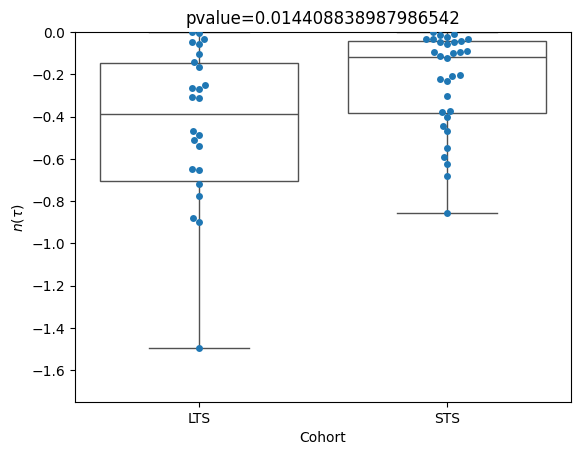

In [ ]:
patnames = list(anl.patients.keys())
data = pd.DataFrame(zip([anl.patients[patname].OS for patname in patnames],[anl.patients[patname].q for patname in patnames]), columns=["OS","ntau"])
data["Cohort"] = ["STS" if os<=2 else "LTS" for os in data.OS]

ax = sns.swarmplot(x='Cohort', y='ntau', data=data, dodge=True)
sns.boxplot(x='Cohort', y='ntau', data=data,
                    boxprops={'facecolor': 'None'})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], frameon=False)
x1 = data[data.Cohort == 'STS']['ntau']
x2 = data[data.Cohort != 'STS']['ntau']
try:
    pval = scipy.stats.mannwhitneyu(x1, x2, alternative='two-sided').pvalue
except:
    pval = 0.0
ax.set_title("pvalue=" + str(pval))
ax.set_ylim(-1.75,0)
ax.set_ylabel(r'$n(\tau)$')
plt.show()
#plt.savefig(os.path.join(odir1, col + ".pdf"))
#        plt.close()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_response(df, max_tau, sample):
    # Define time points
    tau = np.linspace(0, max_tau, 200)

    # Compute X_alpha(tau) for each clone
    X = []
    for idx, row in df.iterrows():
        X_alpha_tau = row['X0'] * np.exp(row['F'] * tau)
        X.append(X_alpha_tau)

    X = np.array(X)

    # Create figure with two subplots: dynamics and fitness
    fig, (ax_main, ax_bar) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Main stacked area plot
    stack = ax_main.stackplot(tau, X, labels=df['Clone'], alpha=0.85)
    ax_main.set_xlabel(r'$\tau$ (therapy time)')
    ax_main.set_ylabel(r'$X_\alpha(\tau)$')
    ax_main.set_title('Predicted dynamics of cancer cell clones for sample '+sample)
    ax_main.legend(loc='upper right')

    # Fitness bar plot
    bars = ax_bar.bar(df['Clone'], df['F'], color=[s.get_facecolor() for s in stack])
    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_title('Fitness values')
    ax_bar.set_ylabel(r'$F_\alpha$')
    ax_bar.set_xticks(range(len(df['Clone'])))
    ax_bar.set_xticklabels(df['Clone'])

    plt.tight_layout()
    plt.show()

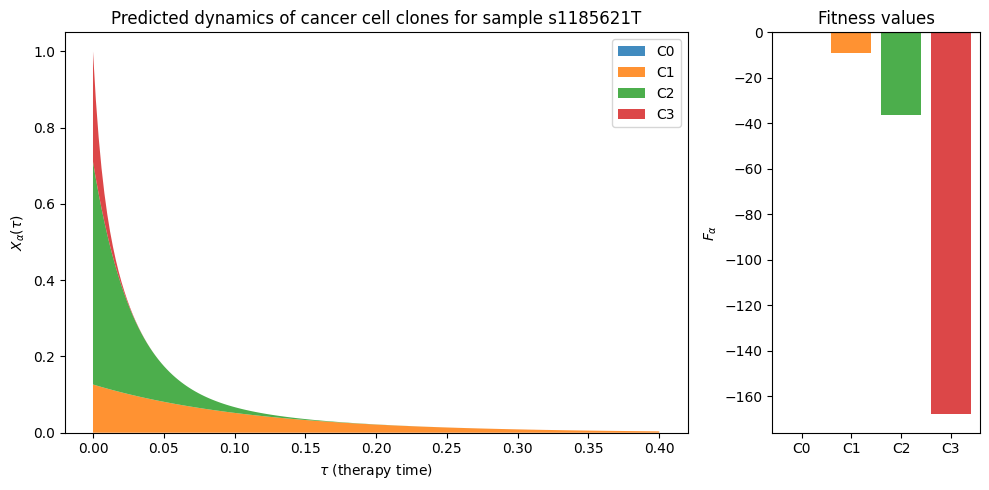

In [ ]:
sample_statistics = anl.sample_statistics(kd_thr=args.kd_thr)
fitness_statistics = anl.fitness_sample_statistics()
#sample_statistics.to_csv(os.path.join(odir, "sample_statistics.txt"), sep="\t", index=False)
#fitness_statistics.to_csv(os.path.join(odir, "fitness_sample_statistics.txt"), sep="\t", index=False)

ntaus = [np.exp(pat.q) for pat in anl.patients.values()]
#ntaus.sort()
#plt.hist(ntaus,bins=np.arange(0,1.01,0.05))
#plt.xlabel(r'$n(\tau)$')
#plt.show()
#plt.savefig(os.path.join(odir, "ntau_hist.pdf"))
#plt.close()

#outdir_trees = os.path.join(odir, 'Tree_plots')
#if not os.path.exists(outdir_trees):
#    os.mkdir(outdir_trees)

for patname in anl.patients:
    patient = anl.patients[patname]
    plottree = PlotTreeAll(patient, drivers=["TP53","KRAS"], tid=0, save_html=False, show=True)
    df=pd.DataFrame([["C"+str(node.id), node.Y,node.fitness] for node in anl.samples[patname].trees[0].nodes.values()],columns=["Clone","X0","F"])
    plot_response(df, 0.4, patname)
    break